In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
# from ms_statescript_event import StatescriptEvents

# StatescriptEvents()
import spyglass.common as sgc

[2024-01-18 15:07:12,295][INFO]: Connecting sambray@lmf-db.cin.ucsf.edu:3306
[2024-01-18 15:07:12,329][INFO]: Connected sambray@lmf-db.cin.ucsf.edu:3306


In [2]:
import copy
import itertools
import os
import re
import numpy as np
import pandas as pd
import scipy as sp
import operator
import scipy.stats as stats
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from spectral_connectivity import Multitaper, Connectivity

import datajoint as dj
import spyglass
from spyglass.common import (Session, IntervalList, LabMember, LabTeam, Raw, Session, Nwbfile, TaskEpoch,
                             Electrode, ElectrodeGroup, LFP, LFPSelection, LFPBand, LFPBandSelection)
from spyglass.common.common_position import (RawPosition, IntervalPositionInfo)

os.chdir("/home/sambray/Documents/behavioral_analysis_AS/")
from AS_EM_module import EM_main

os.chdir("/home/sambray/Documents/MS_analysis_Jen/")
from populate_lfp_tables import populate_lfp_tables, populate_LFPBandSelection_theta
from ms_dio_event import DioEvents, ProcessedDioEvents
from ms_task_identification import TaskIdentification
from ms_interval import EpochIntervalListName
from metadata_helpers import get_ms_nwbf_epoch_keys
from df_helpers import df_pop, df_filter1_columns, df_from_data_list
from nwbf_helpers import get_nwb_file
from datajoint_table_helpers import format_nwb_file_name
from vector_helpers import unpack_single_element
from populate_position_tables import populate_position_info_table
from plot_helpers import format_ax
from stats_helpers import average_confidence_interval, circular_shuffle
from point_process_helpers import event_times_in_intervals_bool
from ms_dio_event import *
from ms_task_performance import *

os.chdir('/home/sambray/Documents/MS_analysis_samsplaying/')
from ms_opto_stim_protocol import OptoStimProtocol
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>")) # set cells to be wide

/tmp/ipykernel_1780555/1622852462.py:43: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [54]:
(TaskIdentification * EpochIntervalListName).fetch('contingency')
TaskIdentification* EpochIntervalListName
OptoStimProtocol & {'nwb_file_name':'Winnie20220714_.nwb'}

nwb_file_name name of the NWB file,interval_list_name descriptive name of this interval list,dio_event_name the name assigned to this DIO event,opto_infer_params_name name for this set of parameters,optogenetic_protocol name of optogenetic protocol type (e.g. pulse train),pulse_length_ms length of individual pulse,inter_pulse_interval_ms time between pulses in a train (= np.nan if pulses_per_train=1 or phase-targeting feedback),inter_train_interval_ms time between end of train and start of new one (= np.nan if phase-targeting feedback),period_ms time between successive train starts (= np.nan if phase-targeting feedback),pulses_per_train number of pulses in a train,number_trains mean number of train events observed between behavior-off intervals,stim_on whether any optogenetic stimulus occured in this interval,test_intervals numpy array with start and end times for each interval optogenetics is running,control_intervals numpy array with start and end times for each interval optogenetics is off


## Populate behavior analysis tables

In [36]:
import warnings
warnings.filterwarnings('ignore')

# Populate tables for behavioral analysis of W track sessions
nwb_file_names = ["Wallie20220922_.nwb", "Winnie20220720_.nwb", "Totoro20220613_.nwb", "Totoro20220614_.nwb", "Yoshi20220517_.nwb", "Winnie20220719_.nwb",
                 "Winnie20220719_.nwb",] # "Banner20220224_.nwb", "Totoro20220613_.nwb", "Olive20220711_.nwb",  "Wallie20220922_.nwb"] 
nwb_file_names = ["Banner20220224_.nwb",]

nwb_file_names = ["Yoshi20220518_.nwb","Yoshi20220519_.nwb"]
nwb_file_names = ["Banner20220224_.nwb",]
nwb_file_names = ["Yoshi20220509_.nwb"]
nwb_file_names = ["Frodo20230814_.nwb","Frodo20230815_.nwb","Frodo20230816_.nwb","Winnie20220719_.nwb",
                 "Winnie20220719_.nwb","Bilbo20230802_.nwb","Bilbo20230804_.nwb"]
nwb_file_names = [x for x in nwb_file_names if 'Winnie' in x]
nwb_file_names = ["Winnie20220719_.nwb","Winnie20220720_.nwb",]
nwb_file_names = ['Frodo20230815_.nwb']
# nwb_file_names = ['Winnie20220719_.nwb']
for nwb_file_name in nwb_file_names:
    print(f"on {nwb_file_name}...")
    key = {"nwb_file_name": nwb_file_name}
    if not TaskIdentification & key:
        TaskIdentification.populate(key)
    epochs = []
    for contingency in ['lineartrack','Lineartrack','wtrack','Wtrack','w-track','W-Track']:
        epochs.extend((TaskIdentification & {**key, **{"contingency": contingency}}).fetch("epoch"))
    # epochs = np.append((TaskIdentification & {**key, **{"contingency": "wtrack"}}).fetch("epoch"),(TaskIdentification & {**key, **{"contingency": "lineartrack"}}).fetch("epoch"))
    for epoch in epochs:
        print(f"on epoch {epoch}...")
        key.update({"epoch": epoch})
        if not EpochIntervalListName & key:
            print('populating epochIntervalListName')
            EpochIntervalListName.populate(key)
        if not DioEvents & key:
            print ('DioEvents')
            DioEvents.populate(key)
        if not ProcessedDioEvents & key:
            print('ProcessedDioEvents')
            ProcessedDioEvents.populate(key)
        if not AlternationTaskPerformance & key:
            print('AlternationTaskPerformance')
            AlternationTaskPerformanceSel().insert1(key,skip_duplicates=True)
            AlternationTaskPerformance.populate(key)

on Frodo20230815_.nwb...
on epoch 2...
on epoch 4...
on epoch 6...
populating epochIntervalListName
on epoch 8...
populating epochIntervalListName
on epoch 10...
on epoch 2...
on epoch 4...
on epoch 6...
populating epochIntervalListName
on epoch 8...
populating epochIntervalListName
on epoch 10...


In [54]:
key = {'nwb_file_name': 'Frodo20230815_.nwb' }#, 'epoch': 6}
EpochIntervalListName.populate(key)
EpochIntervalListName & key

# from spyglass.common import TaskEpoch,IntervalList
# TaskEpoch & key
# (IntervalList & key)#.fetch('interval_list_name')

KeyboardInterrupt: 

In [55]:
AlternationTaskPerformance & key

nwb_file_name name of the NWB file,epoch the session epoch for this task and apparatus(1 based),previous_side_wells,previous_wells,current_wells,reward_outcomes,performance_outcomes
Frodo20230815_.nwb,2,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=
Frodo20230815_.nwb,4,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=
Frodo20230815_.nwb,6,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=
Frodo20230815_.nwb,8,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=
Frodo20230815_.nwb,10,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=


In [28]:
x = (ProcessedDioEvents&key).fetch("KEY")[0]
(TaskIdentification & x).fetch1("contingency") in ["wtrack","W-Track","W-track",'wtrack','w-track']
# ProcessedDioEvents & key
AlternationTaskPerformanceSel.insert1(x,skip_duplicates=True)

AlternationTaskPerformanceSel&x #& key

AlternationTaskPerformance.populate(x)
# key

Added entry to AlternationTaskPerformance for {'nwb_file_name': 'Bilbo20230804_.nwb', 'epoch': 4, 'previous_side_wells': array(['none', 'none', 'left_well', 'left_well', 'left_well', 'left_well',
       'right_well', 'right_well', 'left_well', 'left_well', 'right_well',
       'right_well', 'right_well', 'right_well', 'left_well', 'left_well',
       'right_well', 'right_well', 'left_well', 'left_well', 'left_well',
       'left_well', 'right_well', 'right_well', 'left_well', 'left_well',
       'right_well', 'right_well', 'left_well', 'left_well', 'right_well',
       'right_well', 'left_well', 'left_well', 'right_well', 'right_well',
       'left_well', 'left_well', 'left_well', 'left_well', 'right_well',
       'right_well', 'left_well', 'left_well', 'right_well', 'right_well',
       'left_well', 'left_well', 'right_well', 'right_well', 'left_well',
       'left_well', 'left_well', 'left_well', 'right_well', 'right_well',
       'left_well', 'left_well', 'right_well', 'right_well',

In [32]:
AlternationTaskPerformance & key

nwb_file_name name of the NWB file,epoch the session epoch for this task and apparatus(1 based),previous_side_wells,previous_wells,current_wells,reward_outcomes,performance_outcomes
Bilbo20230804_.nwb,4,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=


In [7]:
TaskIdentification&key
(TaskIdentification & {**key, **{"contingency": "lineartrack"}}).fetch("epoch")

array([ 2,  4,  6,  8, 10, 12, 14, 16, 18])

In [76]:
key = {'nwb_file_name': 'Frodo20230814_.nwb', 'epoch': 10}
# print((ProcessedDioEvents() & key).fetch1_dataframe().dio_event_names.values.size)
wells = (AlternationTaskPerformance & key).fetch('current_wells')[0]
reward = (AlternationTaskPerformance & key).fetch('reward_outcomes')[0]

for w,r in zip(wells,reward):
    print(w,r)  

center_well reward
left_well reward
center_well reward
right_well reward
center_well reward
left_well reward
center_well reward
left_well no_reward
center_well reward
right_well reward
center_well reward
left_well reward
center_well reward
right_well reward
center_well reward
left_well reward
center_well reward
right_well reward
center_well reward
right_well no_reward
center_well reward
right_well no_reward
center_well reward
left_well reward
center_well reward
right_well reward
center_well reward
right_well no_reward
center_well reward
right_well no_reward
center_well reward
right_well no_reward
center_well reward
left_well reward
center_well reward
right_well reward
center_well reward
right_well no_reward
center_well reward
right_well no_reward
center_well reward
left_well reward
center_well reward
right_well reward
center_well reward
left_well reward
center_well reward
left_well no_reward
center_well reward
right_well reward
center_well reward
left_well reward
center_well reward


In [74]:
w

array(['center_well', 'right_well', 'center_well', 'left_well',
       'center_well', 'right_well', 'center_well', 'left_well',
       'center_well', 'right_well', 'center_well', 'right_well',
       'center_well', 'right_well', 'left_well', 'center_well',
       'right_well', 'center_well', 'left_well', 'center_well',
       'right_well', 'center_well', 'right_well', 'center_well',
       'left_well', 'center_well', 'left_well', 'center_well',
       'left_well', 'right_well'], dtype=object)

## Get performance outcomes across epochs on w track, for each animal and for each trial type

In [6]:
# Get performance outcomes across epochs on w track, for each animal and for each trial type
#single day
nwb_file_names_map = {
                      "Yoshi": ["Yoshi20220517_.nwb",],#"Yoshi20220518_.nwb",],
                      "Olive": ["Olive20220711_.nwb"],
                      "Wallie": ["Wallie20220922_.nwb"],
                      "Bilbo":["Bilbo20230802_.nwb",],#"Bilbo20230804_.nwb"],# no entrainment
                      "Totoro": ["Totoro20220613_.nwb",],# "Totoro20220614_.nwb"],
                      "Winnie": ["Winnie20220719_.nwb",],# "Winnie20220720_.nwb"],
                      "Banner":["Banner20220224_.nwb",],#"Banner20220225_.nwb"],
                      "Frodo":["Frodo20230814_.nwb",],#"Frodo20230815_.nwb","Frodo20230816_.nwb",]
                      }  # entrainment  # 
#single day
nwb_file_names_map = {
                      "Yoshi": ["Yoshi20220517_.nwb","Yoshi20220518_.nwb",],
                      "Olive": ["Olive20220711_.nwb"],
                      "Wallie": ["Wallie20220922_.nwb"],
                      "Bilbo":["Bilbo20230802_.nwb","Bilbo20230804_.nwb"],# no entrainment
                      "Totoro": ["Totoro20220613_.nwb", "Totoro20220614_.nwb"],
                      "Winnie": ["Winnie20220719_.nwb", "Winnie20220720_.nwb"],
                      "Banner":["Banner20220224_.nwb","Banner20220225_.nwb"],
                      "Frodo":["Frodo20230814_.nwb",],#"Frodo20230815_.nwb","Frodo20230816_.nwb",]
                      }  

# #Frodo with and without stim
# nwb_file_names_map = {
#     "Frodo_stim": ["Frodo20230814_.nwb","Frodo20230815_.nwb"],
#     "Frodo_no_stim": ["Frodo20230815_.nwb","Frodo20230816_.nwb"]
# }

# entrainment  # 
# nwb_file_names_map = {"Frodo":["Frodo20230814_.nwb","Frodo20230815_.nwb","Frodo20230816_.nwb",]}
# nwb_file_names_map = {"Winnie": ["Winnie20220719_.nwb", "Winnie20220720_.nwb"],}
# nwb_file_names_map = {"Bilbo":["Bilbo20230802_.nwb","Bilbo20230804_.nwb"]}
# nwb_file_names_map={"Wallie": ["Wallie20220922_.nwb"],"Totoro": ["Totoro20220613_.nwb","Totoro20220614_.nwb"]}#"Banner":["Banner20220224_.nwb"]}
# nwb_file_names_map = {"Banner24":["Banner20220224_.nwb",],
#                      "Banner25":["Banner20220225_.nwb"],
#                      "Banner":["Banner20220224_.nwb","Banner20220225_.nwb",]} 
trial_types = ["all", "outbound", "inbound"]
optogenetic_types = ['control','test']

data_list = []  # initialize list to store correct/incorrect outcomes 
# For nwb file names

for optogenetics in optogenetic_types:
    for rat_name, nwb_file_names in nwb_file_names_map.items():
        # Loop through trial types
        for trial_type in trial_types:
            resp_values = []
            # Loop through epochs where contingency is wtrack
            total_trial_count = 0
            trial_number = []
            for nwb_file_name in nwb_file_names:
                key = {"nwb_file_name": nwb_file_name}
                # Get epochs where contingency is wtrack
                epochs = []
                for contingency in ['wtrack','w-track']:
                    epochs.extend((TaskIdentification & {**key, **{"contingency": contingency}}).fetch("epoch"))
                if rat_name=='Frodo_stim' and nwb_file_name=='Frodo20230815_.nwb':
                    epochs = [2,4]
                if rat_name=='Frodo_no_stim' and nwb_file_name=='Frodo20230815_.nwb':
                    epochs = np.array(epochs)
                    epochs = epochs[epochs>5]
                print(key)
                print('Epochs:',epochs)
                
                for epoch in epochs:
                    key.update({"epoch": epoch})
    
                    # Get performance outcomes
                    table_intersection = (AlternationTaskPerformance & key)
                    if len(table_intersection) == 0:
                        print(f"no entry found in AlternationTaskPerformance for {key}")
                        continue
                    performance_outcomes = table_intersection.fetch1("performance_outcomes")
                    #SB: restrict by optogenetic period or control
                    if optogenetics in ['test','control']:
                        poke_event_times = (ProcessedDioEvents.FirstUpPokes() & key).fetch1("dio_first_poke_times")
                        # get the control interval
                        if EpochIntervalListName()&key:
                            pos_interval_name = (EpochIntervalListName()&key).fetch1('interval_list_name')
                            dio_info_key = {"nwb_file_name": nwb_file_name, "interval_list_name":pos_interval_name, 'dio_event_name':'stim'}
                            control_interval = OptoStimProtocol().get_control_intervals(dio_info_key)#[0][0]
                            if len(control_interval)==0:
                                print('missing parameterized optogenetics: ', dio_info_key)
                                continue
                            control_interval=control_interval[0][0]
                        else:
                            print(f'No position tracking for {key}. Assuming no stimulus interval')
                            control_interval = [0,1e20]
 
                        #label each event as in test or control
                        optogenetic_event = [(event_time<control_interval[0] or event_time>control_interval[1]) for event_time in poke_event_times]
                        # Restrict to inbound or outbound if indicated
                        if trial_type in ["inbound", "outbound"]:
                            optogenetic_event = [y for (x,y) in zip(performance_outcomes,optogenetic_event) if trial_type in x]
                            performance_outcomes = [x for x in performance_outcomes if trial_type in x]
                        epoch_trial_number = np.arange(len(performance_outcomes)) + total_trial_count
                        total_trial_count += len(epoch_trial_number)
                        #filter on condition
                        performance_outcomes = [x for (x,opto) in zip(performance_outcomes,optogenetic_event) if ((opto and optogenetics=='test') or ((not opto) and optogenetics=='control'))]             
                        epoch_trial_number = [x for (x,opto) in zip(epoch_trial_number,optogenetic_event) if ((opto and optogenetics=='test') or ((not opto) and optogenetics=='control'))]
                        
                    else: #no optogenetic restriction
                        # Restrict to inbound or outbound if indicated
                        if trial_type in ["inbound", "outbound"]:
                            performance_outcomes = [x for x in performance_outcomes if trial_type in x]
                        epoch_trial_number = np.arange(len(performance_outcomes)) + total_trial_count
                        total_trial_count += len(epoch_trial_number)
                    
                    # Convert to binary
                    performance_outcomes = np.asarray(performance_outcomes_to_int(performance_outcomes))
    
                    # Remove nans
                    resp_values.extend(performance_outcomes[np.isfinite(performance_outcomes)])
                    trial_number.extend(np.array(epoch_trial_number)[np.isfinite(performance_outcomes)])
                    
            # Store result
            data_list.append((rat_name, trial_type, resp_values, optogenetics, trial_number))
# Convert results to df
res_values_df = df_from_data_list(data_list, ["rat_name", "trial_type", "resp_values", "optogenetic_type", "trial_number"])

{'nwb_file_name': 'Yoshi20220517_.nwb'}
Epochs: [2, 4, 6, 8, 10, 12, 14, 16]
{'nwb_file_name': 'Yoshi20220518_.nwb'}
Epochs: [2, 4, 6, 8, 10, 12, 14, 16]
{'nwb_file_name': 'Yoshi20220517_.nwb'}
Epochs: [2, 4, 6, 8, 10, 12, 14, 16]
{'nwb_file_name': 'Yoshi20220518_.nwb'}
Epochs: [2, 4, 6, 8, 10, 12, 14, 16]
{'nwb_file_name': 'Yoshi20220517_.nwb'}
Epochs: [2, 4, 6, 8, 10, 12, 14, 16]
{'nwb_file_name': 'Yoshi20220518_.nwb'}
Epochs: [2, 4, 6, 8, 10, 12, 14, 16]
{'nwb_file_name': 'Olive20220711_.nwb'}
Epochs: [2, 4, 6, 8, 10, 12, 14, 16]
{'nwb_file_name': 'Olive20220711_.nwb'}
Epochs: [2, 4, 6, 8, 10, 12, 14, 16]
{'nwb_file_name': 'Olive20220711_.nwb'}
Epochs: [2, 4, 6, 8, 10, 12, 14, 16]
{'nwb_file_name': 'Wallie20220922_.nwb'}
Epochs: [2, 4, 6, 8, 10, 12, 14, 16, 18, 20]
{'nwb_file_name': 'Wallie20220922_.nwb'}
Epochs: [2, 4, 6, 8, 10, 12, 14, 16, 18, 20]
{'nwb_file_name': 'Wallie20220922_.nwb'}
Epochs: [2, 4, 6, 8, 10, 12, 14, 16, 18, 20]
{'nwb_file_name': 'Bilbo20230802_.nwb'}
Epochs: [

In [39]:
key = {'nwb_file_name': 'Frodo20230816_.nwb',}
EpochIntervalListName()&key
# key

nwb_file_name name of the NWB file,epoch the session epoch for this task and apparatus(1 based),interval_list_name descriptive name of this interval list
Frodo20230816_.nwb,2,pos 1 valid times
Frodo20230816_.nwb,4,pos 3 valid times


# Plot Learning curves

<>:25: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:25: SyntaxWarning: "is" with a literal. Did you mean "=="?
/tmp/ipykernel_1210019/1046978295.py:25: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if optogenetics is "test":


sigma2e: 0.25
Converged after 278 iterations
sigma2e is  0.019127260759661122


/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


sigma2e: 0.25
Converged after 408 iterations
sigma2e is  0.011235810878329556


/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


sigma2e: 0.25
Converged after 270 iterations
sigma2e is  0.017018839646159776


/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


sigma2e: 0.25
Converged after 268 iterations
sigma2e is  0.00817694816270138


/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
/tmp/ipykernel_1210019/1046978295.py:42: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


sigma2e: 0.25
Converged after 205 iterations
sigma2e is  0.1262273663157757


/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


sigma2e: 0.25
Converged after 296 iterations
sigma2e is  0.13977807871021583


/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
/tmp/ipykernel_1210019/1046978295.py:42: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


sigma2e: 0.25
Converged after 227 iterations
sigma2e is  0.09915476868595878


/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


sigma2e: 0.25
Converged after 296 iterations
sigma2e is  0.013225785358501392


/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
/tmp/ipykernel_1210019/1046978295.py:42: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


sigma2e: 0.25
Converged after 92 iterations
sigma2e is  0.2448017776016345


/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


sigma2e: 0.25
Converged after 272 iterations
sigma2e is  0.02545366456488305


/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
/tmp/ipykernel_1210019/1046978295.py:42: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


sigma2e: 0.25
Converged after 129 iterations
sigma2e is  0.1776008184873779


/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


sigma2e: 0.25
Converged after 271 iterations
sigma2e is  0.06238394183718512


/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
/tmp/ipykernel_1210019/1046978295.py:42: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


sigma2e: 0.25
Converged after 242 iterations
sigma2e is  0.012800290968438755


/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


sigma2e: 0.25
Converged after 274 iterations
sigma2e is  0.006741741800896018


/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
/tmp/ipykernel_1210019/1046978295.py:42: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


sigma2e: 0.25
Converged after 259 iterations
sigma2e is  0.006382929799813952


/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


sigma2e: 0.25
Converged after 300 iterations
sigma2e is  0.00418453648583955


/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
/tmp/ipykernel_1210019/1046978295.py:42: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


sigma2e: 0.25
Converged after 192 iterations
sigma2e is  0.14438423448715051


/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


sigma2e: 0.25
Converged after 399 iterations
sigma2e is  0.14223708438086588


/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
/tmp/ipykernel_1210019/1046978295.py:42: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


sigma2e: 0.25
Converged after 207 iterations
sigma2e is  0.012414148630620023


/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


sigma2e: 0.25
Converged after 360 iterations
sigma2e is  0.00998516488028729


/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
/tmp/ipykernel_1210019/1046978295.py:42: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


sigma2e: 0.25
Converged after 216 iterations
sigma2e is  0.023595512478769943


/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


sigma2e: 0.25
Converged after 235 iterations
sigma2e is  0.007657361673643653


/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
/tmp/ipykernel_1210019/1046978295.py:42: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


sigma2e: 0.25
Converged after 181 iterations
sigma2e is  0.09797998187113825


/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


sigma2e: 0.25
Converged after 204 iterations
sigma2e is  0.15839555374751615


/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
/tmp/ipykernel_1210019/1046978295.py:42: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


sigma2e: 0.25
Converged after 224 iterations
sigma2e is  0.009995057487287202


/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


sigma2e: 0.25
Converged after 263 iterations
sigma2e is  0.002242077768721499


/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
/tmp/ipykernel_1210019/1046978295.py:42: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


sigma2e: 0.25
Converged after 258 iterations
sigma2e is  0.0019346565729511272


/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


sigma2e: 0.25
Converged after 320 iterations
sigma2e is  0.002400164855646392


/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
/tmp/ipykernel_1210019/1046978295.py:42: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


sigma2e: 0.25
Converged after 171 iterations
sigma2e is  0.09617896136907125


/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


sigma2e: 0.25
Converged after 334 iterations
sigma2e is  0.06693413518205646


/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
/tmp/ipykernel_1210019/1046978295.py:42: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


sigma2e: 0.25
Converged after 253 iterations
sigma2e is  0.018655442653900123


/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


sigma2e: 0.25
Converged after 385 iterations
sigma2e is  0.014645986895263915


/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
/tmp/ipykernel_1210019/1046978295.py:42: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


sigma2e: 0.25
Converged after 190 iterations
sigma2e is  0.030948971104164533


/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


sigma2e: 0.25
Converged after 316 iterations
sigma2e is  0.01971979633755384


/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
/tmp/ipykernel_1210019/1046978295.py:42: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


sigma2e: 0.25
Converged after 250 iterations
sigma2e is  0.10656658330180872


/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


sigma2e: 0.25
Converged after 269 iterations
sigma2e is  0.08046923910665191


/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
/tmp/ipykernel_1210019/1046978295.py:42: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


sigma2e: 0.25
Converged after 353 iterations
sigma2e is  0.012519198879906995


/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


sigma2e: 0.25
Converged after 377 iterations
sigma2e is  0.006177248009774466


/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
/tmp/ipykernel_1210019/1046978295.py:42: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


sigma2e: 0.25
Converged after 512 iterations
sigma2e is  0.0027348695251185606


/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


sigma2e: 0.25
Converged after 409 iterations
sigma2e is  0.007281702081053736


/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
/tmp/ipykernel_1210019/1046978295.py:42: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


sigma2e: 0.25
Converged after 190 iterations
sigma2e is  0.10142261198304194


/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


sigma2e: 0.25
Converged after 417 iterations
sigma2e is  0.09398789275309775


/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
/tmp/ipykernel_1210019/1046978295.py:42: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


sigma2e: 0.25
Converged after 239 iterations
sigma2e is  0.01624241974233781


/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


sigma2e: 0.25
Converged after 337 iterations
sigma2e is  0.003808053027824427


/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
/tmp/ipykernel_1210019/1046978295.py:42: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


sigma2e: 0.25
Converged after 236 iterations
sigma2e is  0.0016474975488908676


/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


sigma2e: 0.25
Converged after 313 iterations
sigma2e is  0.002222008228441864


/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
/tmp/ipykernel_1210019/1046978295.py:42: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


sigma2e: 0.25
Converged after 109 iterations
sigma2e is  0.1655904705774191


/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


sigma2e: 0.25
Converged after 403 iterations
sigma2e is  0.03188188541921167


/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
/tmp/ipykernel_1210019/1046978295.py:42: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


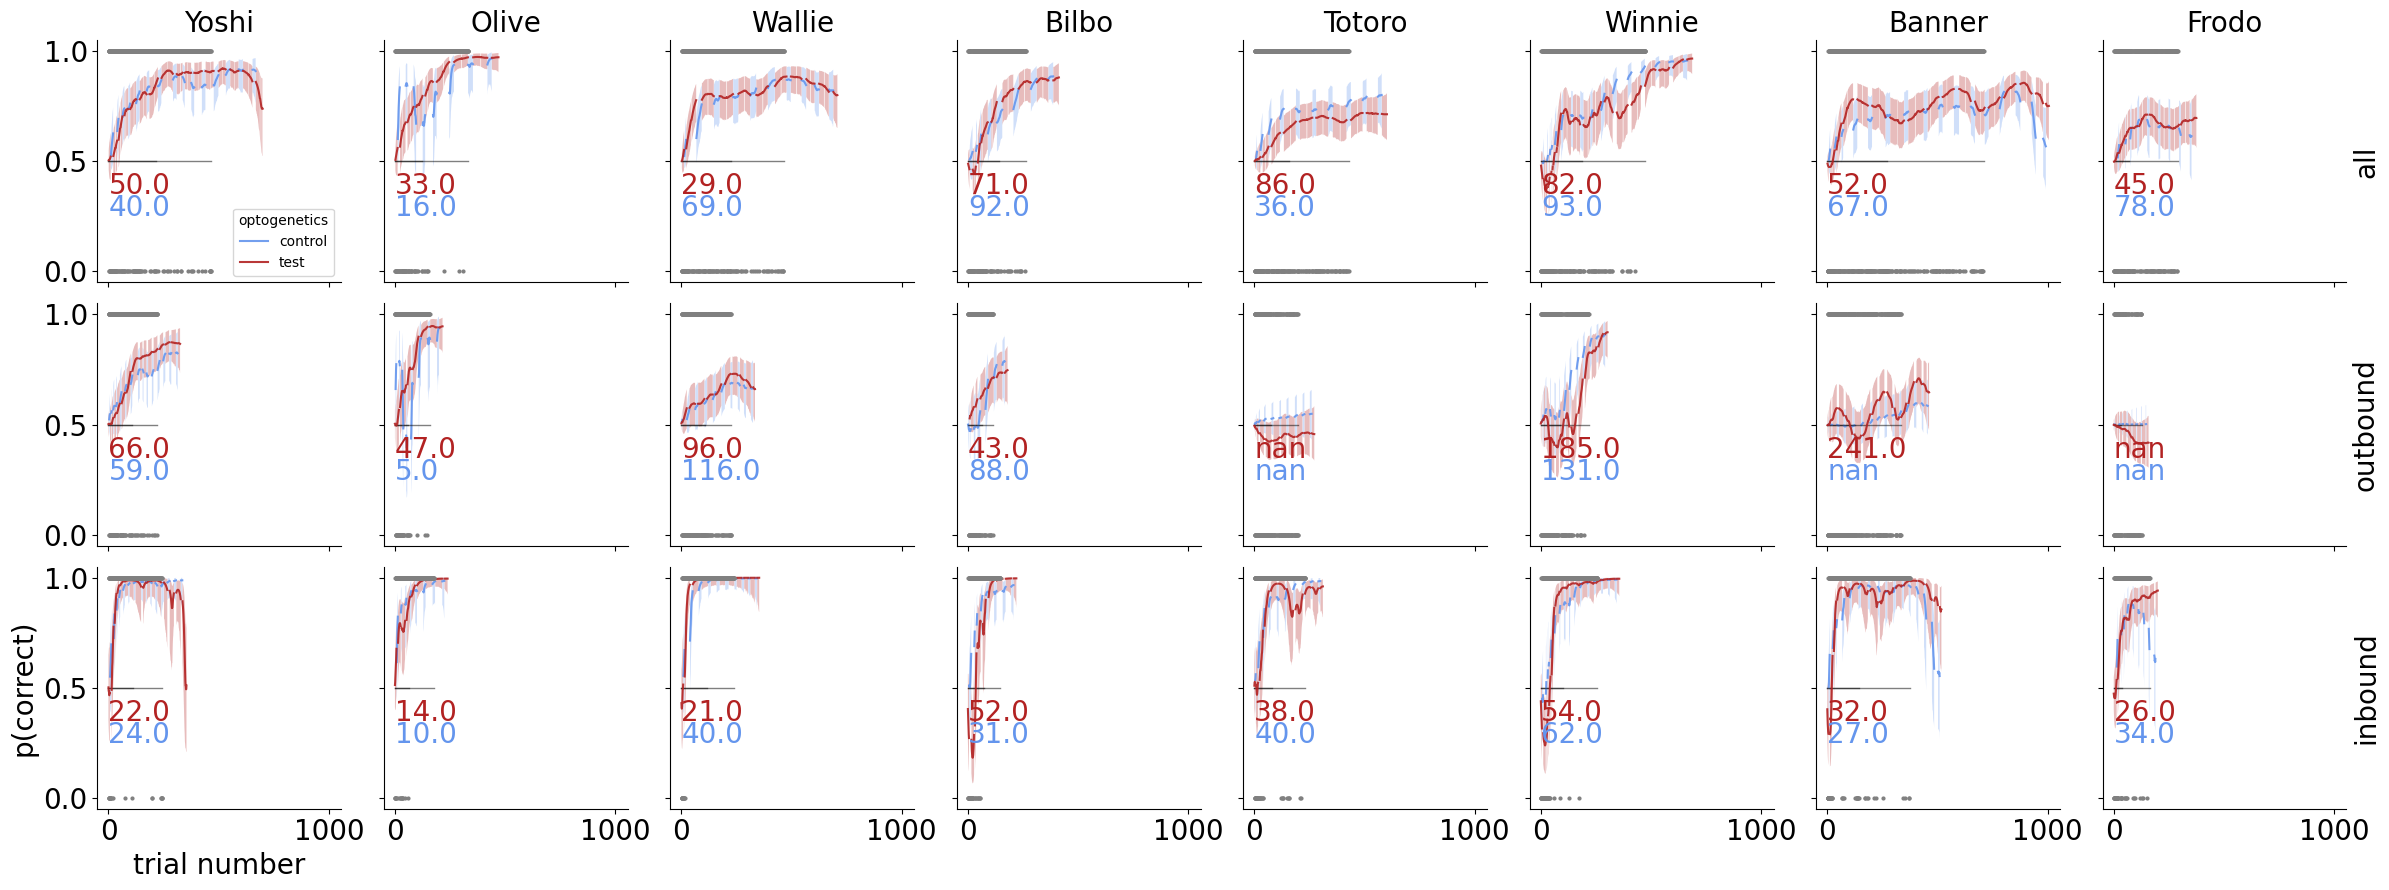

In [7]:
os.chdir("/home/sambray/Documents/behavioral_analysis_AS")
from AS_EM_module import EM_main, RunEM

# Plot parameters
p_init = .5
subplot_width = 3
subplot_height = 3

# Initialize figure
num_columns = max(len(nwb_file_names_map),2)
num_rows = len(trial_types)
fig, axes = plt.subplots(num_rows, num_columns, figsize=(subplot_width*num_columns, subplot_height*num_rows), sharex=True, sharey=True)

# Plot learning curves
data_list = []
for rat_name_idx, rat_name in enumerate(list(nwb_file_names_map.keys())):
    for trial_type_idx, trial_type in enumerate(trial_types):
        for optogenetics,color in zip (optogenetic_types,['cornflowerblue','firebrick']) :
            resp_values = df_pop(res_values_df, {"rat_name": rat_name, "trial_type": trial_type,'optogenetic_type':optogenetics,}, "resp_values")
            trial_number = df_pop(res_values_df, {"rat_name": rat_name, "trial_type": trial_type,'optogenetic_type':optogenetics,}, "trial_number")
            if len(resp_values) == 0:
                continue
            fig_ax_list = [fig, axes[trial_type_idx, rat_name_idx]]
            opto_label = "control"
            if optogenetics is "test":
                opto_label = "septal-transfected"
            fig, ax, pll, pul, pmode = EM_main(resp_values, p_init, fig_ax_list,color=color,label=optogenetics,trial_number=trial_number)
            # Store lower limit 
            data_list.append((rat_name, trial_type, pll,optogenetics,trial_number,pmode))
            title = ""
            ylabel = ""
            xlabel = ""
            if trial_type_idx == 0:
                title = rat_name
            if trial_type_idx == len(trial_types) - 1 and rat_name_idx == 0:
                ylabel = "p(correct)"
                xlabel = "trial number"
            if rat_name_idx == len(nwb_file_names_map)-1:
                ylabel=trial_type
                ax.yaxis.set_label_position("right")
        format_ax(ax=ax, title=title, xlabel=xlabel, ylabel=ylabel)
        fig.tight_layout()
        
# Add text to indicate learning trial
def get_first_entry_else_nan(x):
    if len(x) == 0:
        return np.nan
    return x[0]
pll_df = df_from_data_list(data_list, ["rat_name", "trial_type", "pll","optogenetic_type","trial_number","pmode"])
learning_trials = [get_first_entry_else_nan(np.where(pll > .5)[0]) for pll in pll_df.pll]
def indxVal_else_nan(values,indx):
    if indx is np.nan:
        return np.nan
    return values[indx]
learning_trials = [indxVal_else_nan(trial_number,ind) for(trial_number, ind) in zip(pll_df.trial_number,learning_trials)]
pll_df["learning_trial"] = learning_trials

for rat_name_idx, rat_name in enumerate(nwb_file_names_map.keys()):
    for trial_type_idx, trial_type in enumerate(trial_types):
        for loc,(optogenetics,color) in enumerate(zip(optogenetic_types,['cornflowerblue','firebrick'])):
            resp_values = df_pop(res_values_df, {"rat_name": rat_name, "trial_type": trial_type,'optogenetic_type':optogenetics}, "resp_values")
            if len(resp_values) == 0:
                continue
            learning_trial = df_pop(pll_df, {"rat_name": rat_name, "trial_type": trial_type,'optogenetic_type':optogenetics}, "learning_trial")
            ax = axes[trial_type_idx, rat_name_idx]
            ax.text(0, .25+.1*loc, learning_trial, fontsize=20,color=color)
axes[0,0].legend(loc='lower right',title='optogenetics')

In [7]:
plt.rcParams['svg.fonttype']='none'
os.chdir('/home/sambray/Documents/MS_analysis_samsplaying/Plots/')
fig.savefig('20230724_wTrack_curves_separated_globalTrialCount_gap.png')
fig.savefig('20230724_wTrack_curves_separated_globalTrialCount_gap.svg')

## Learning Trial comparison

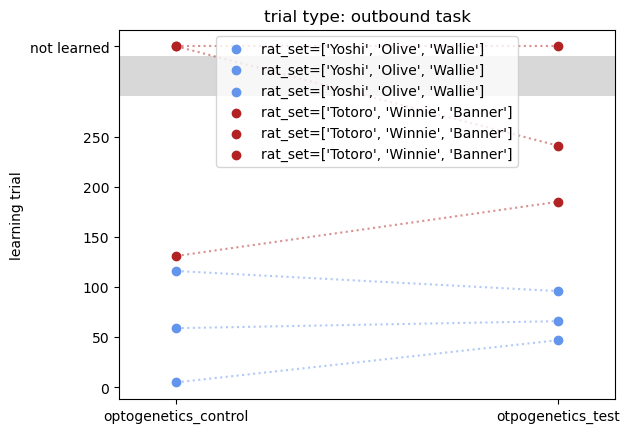

In [93]:
trial_type = 'outbound'
control_rats = ["Yoshi", "Olive", "Wallie"]
opto_rats = ["Totoro", "Winnie", "Banner"]
set_nan = 340
df_ = pll_df[(pll_df['trial_type']==trial_type)].copy()

included_nan = False
for rat_set, color in zip([control_rats, opto_rats],['cornflowerblue','firebrick']):
    for rat_name in rat_set:
        lt_test = df_[(df_['optogenetic_type']=='test') & (df_['rat_name']==rat_name)]['learning_trial']
        lt_control = df_[(df_['optogenetic_type']=='control') & (df_['rat_name']==rat_name)]['learning_trial']
        if any(np.isnan([lt_test,lt_control])):# or np.isnan(lt_control):
            included_nan = True
        lt_test = np.nan_to_num(lt_test,nan=set_nan)
        lt_control = np.nan_to_num(lt_control,nan=set_nan)
        plt.scatter([0,1],[lt_control,lt_test,], color=color,label=f'{rat_set=}')
        plt.plot([0,1],[lt_control,lt_test,], color=color,ls=':', alpha=.5)

plt.legend()
plt.xticks([0,1],labels=['optogenetics_control','otpogenetics_test'])
plt.ylabel('learning trial')
plt.title(f'trial type: {trial_type} task')
plt.xlim(-.15,1.15)
if included_nan:
    plt.fill_between([-1,2],[set_nan-10,set_nan-10],[set_nan-50,set_nan-50],facecolor='grey',alpha = .3)
    yticks = np.append(np.arange(0,251,50),[set_nan])
    yticks_labels = list(yticks.copy())
    yticks_labels[-1] = 'not learned'
    
    plt.yticks(yticks,labels=yticks_labels)

# Correct Fraction First n trials

Text(0.5, 1.0, 'trial type: outbound task, p = 0.019')

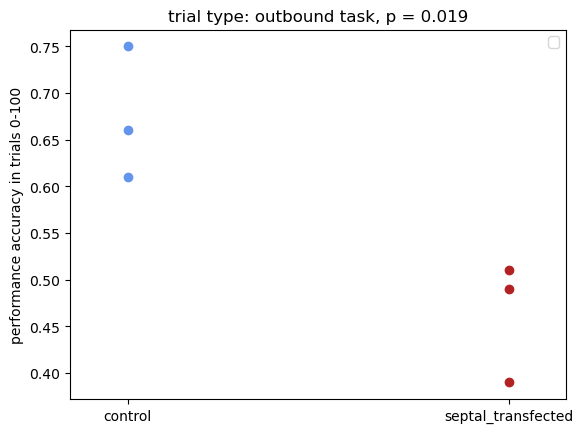

In [77]:
trial_type = 'outbound'
control_rats = ["Yoshi", "Olive", "Wallie"]
opto_rats = ["Totoro", "Winnie", "Banner"]
trial_sample =(0,100)
df_ = res_values_df[(res_values_df['trial_type']==trial_type)].copy()
fig=plt.figure()
results = []
for i,(rat_set, color) in enumerate(zip([control_rats, opto_rats],['cornflowerblue','firebrick'])):
    results.append([])
    for rat_name in rat_set:
        lt_test = np.mean(np.asarray(df_[(df_['optogenetic_type']=='test') & (df_['rat_name']==rat_name)]['resp_values'])[0][trial_sample[0]:trial_sample[1]])
        results[-1].append(lt_test)
    plt.scatter(np.ones_like(results[-1])*i,results[-1],color=color)

    
plt.legend()
plt.xticks([0,1],labels=['control','septal_transfected'])
plt.ylabel('learning trial')
plt.ylabel(f"performance accuracy in trials {trial_sample[0]}-{trial_sample[1]}" )
plt.xlim(-.15,1.15)

from scipy.stats import ttest_ind
plt.title(f'trial type: {trial_type} task, p = {np.round(ttest_ind(*results)[1],3)}')

In [167]:
plt.rcParams['svg.fonttype']='none'
os.chdir('/home/sambray/Documents/MS_analysis_samsplaying/Plots/')
filename = '20230724_performance_accuracy'
fig.savefig(filename+'.png')
fig.savefig(filename+'.svg')

In [153]:
df_[df_['optogenetic_type']=='test']
res_values_df[(pll_df['trial_type']==trial_type)].copy()

,rat_name,trial_type,resp_values,optogenetic_type,trial_number
4,Olive,outbound,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, ...",control,"[3, 4, 5, 6, 19, 20, 21, 22, 33, 34, 35, 36, 3..."
5,Olive,inbound,"[1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, ...",control,"[8, 9, 10, 11, 12, 13, 27, 28, 29, 30, 47, 48,..."
10,Totoro,outbound,"[0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, ...",control,"[2, 3, 7, 8, 9, 10, 20, 21, 22, 23, 24, 25, 44..."
11,Totoro,inbound,"[1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, ...",control,"[4, 5, 6, 18, 19, 20, 21, 22, 23, 40, 41, 42, ..."
16,Banner,outbound,"[0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, ...",control,"[0, 6, 7, 8, 19, 20, 21, 22, 44, 45, 46, 47, 4..."
17,Banner,inbound,"[0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, ...",control,"[6, 7, 8, 9, 10, 11, 25, 26, 27, 28, 29, 41, 4..."
22,Olive,outbound,"[1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, ...",test,"[0, 1, 2, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,..."
23,Olive,inbound,"[0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, ...",test,"[0, 1, 2, 3, 4, 5, 6, 7, 14, 15, 16, 17, 18, 1..."
28,Totoro,outbound,"[0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, ...",test,"[0, 1, 4, 5, 6, 11, 12, 13, 14, 15, 16, 17, 18..."
29,Totoro,inbound,"[0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, ...",test,"[0, 1, 2, 3, 7, 8, 9, 10, 11, 12, 13, 14, 15, ..."


### Learning curve slope

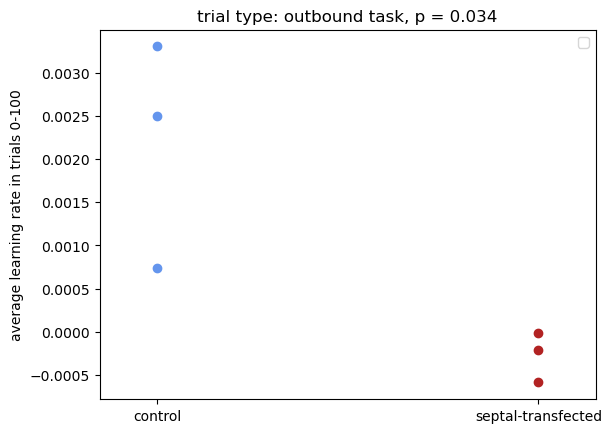

In [75]:
from scipy.stats import linregress

trial_type = 'outbound'
control_rats = ["Yoshi", "Olive", "Wallie"]
opto_rats = ["Totoro", "Winnie", "Banner"]
trial_sample =(0,100)

df_ = pll_df[(pll_df['trial_type']==trial_type)].copy()

fig=plt.figure()
results = []
for i,(rat_set, color) in enumerate(zip([control_rats, opto_rats],['cornflowerblue','firebrick'])):
    results.append([])
    for rat_name in rat_set:
        pmode = np.asarray(df_[(df_['optogenetic_type']=='test') & (df_['rat_name']==rat_name)]['pmode'])[0][trial_sample[0]:trial_sample[1]]
        trial_number =np.asarray(df_[(df_['optogenetic_type']=='test') & (df_['rat_name']==rat_name)]['trial_number'])[0][trial_sample[0]:trial_sample[1]]
        slope = linregress(trial_number,pmode)[0]
        results[-1].append(slope)
    plt.scatter(np.ones_like(results[-1])*i,results[-1],color=color)

plt.legend()
plt.xticks([0,1],labels=['control','septal-transfected'])
plt.ylabel(f"average learning rate in trials {trial_sample[0]}-{trial_sample[1]}" )
plt.xlim(-.15,1.15)

from scipy.stats import ttest_ind
plt.title(f'trial type: {trial_type} task, p = {np.round(ttest_ind(*results)[1],3)}')
plt.rcParams['svg.fonttype']='none'
figname = "/home/sambray/Documents/MS_analysis_samsplaying/Plots/Abhilashsa_20220724/behavior/learning_rate"
fig.savefig(figname+".png")
fig.savefig(figname+".svg")